<a href="https://colab.research.google.com/github/jullyoemmanuel/Debts-Worth-the-Bank-s-Effort/blob/main/Analisando_quais_d%C3%ADvidas_valem_o_esfor%C3%A7o_de_um_banco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Descontinuidade da regressão: recuperação bancária
<center>
<img src="https://drive.google.com/uc?id=1MuAT-NzucCs7IvLf318yKuhRvH--yQ8m" style="width:700px"> <br> 
</center>

Nos bancos estadunidenses, quando uma dívida é legalmente declarada como "incobrável", geralmente a conta do cliente fica definida como <a href="https://www.usbank.com/customer-service/knowledge-base/KB0206698.html">Charged off</a> (é um termo contábil que significa que o credor considera uma dívida como incobrável).






Mas isso não significa que o banco deixa a dívida de lado. Eles ainda querem receber parte do dinheiro que lhes é devido. Para isso, o banco pontuará a conta para avaliar o **Valor de Recuperação Esperado**, ou seja, o valor esperado que o banco poderá receber do cliente no futuro. Esse valor é uma função da probabilidade de pagamento do cliente, da dívida total e de outros fatores que afetam a capacidade e a disposição de pagamento.

O banco do nosso dataset implementou diferentes estratégias de recuperação em diferentes intervalos (\$1.000, \$2.000, etc.), onde quanto maior o valor de recuperação esperado, mais esforço o banco coloca para entrar em contato com o cliente. Para valores baixos de recuperação (Nível 0), o banco apenas adiciona as informações de contato do cliente ao discador automático e ao sistema de e-mail. Para estratégias de recuperação mais altas, o banco incorre em mais custos, pois alavanca recursos humanos em mais esforços para obter pagamentos. 

Cada nível adicional de estratégia de recuperação requer \$50 adicionais por cliente, de modo que os clientes no Nível 1 da Estratégia de Recuperação custem à empresa \$50 a mais do que os do Nível 0. Os clientes no Nível 2 custam \$50 a mais do que os do Nível 1, e assim por diante.

As questões chave são: **Esse processo vale a pena?** A quantia extra recuperada no nível de estratégia mais alto excede os \$50 extras em custos? Em outras palavras, houve um salto (também chamado de "descontinuidade") de mais de \$50 no valor recuperado no nível superior da estratégia? Vamos descobrir neste caderno.

<center>
<img src="https://drive.google.com/uc?id=1b6hPnMCEKLHlMuems6iCvLP0LKWa_Lp7" style="width:800px"> <br> 
</center>


Primeiro, carregaremos o conjunto de dados bancários e examinaremos as primeiras linhas de dados. Isso nos permite entender o próprio conjunto de dados e começar a pensar em como analisar os dados.

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np

# Lendo o dataset
df = pd.read_csv("/content/bank_data.csv")

# Imprimir primeiras 5 linhas do dataset
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


## 2. Análise gráfica exploratória de dados
O banco implementou diferentes estratégias de recuperação em diferentes intervalos (\$1000, \$2000, \$3000 e \$5000) onde quanto maior for o Valor Esperado de Recuperação, mais esforço o banco coloca em contacto com o cliente. Zerar na primeira transição (entre o Nível 0 e o Nível 1) significa que estamos focados na população com Valores Esperados de Recuperação entre \$0 e \$2000 onde a transição entre os Níveis ocorreu em \$1000.

Aqui está um rápido resumo dos níveis e limites novamente:

* Nível 0: Valores de recuperação esperados &gt; \$0 e &lt;= \$1000
* Nível 1: Valores de recuperação esperados &gt; \$1000 e &lt;= \$2000
* Nosso limite entre os níveis 0 e 1 é $1000

Uma questão-chave é se existem outros fatores além do Valor de Recuperação Esperado que também variaram sistematicamente ao longo do limite de \$1.000. Por exemplo, a idade do cliente mostra um salto (descontinuidade) no limite de \$1.000 ou essa idade varia suavemente? Podemos examinar isso fazendo primeiro um gráfico de dispersão da idade como uma função do Valor Esperado de Recuperação para uma pequena janela do Valor Esperado de Recuperação, \$0 a \$2000. Este intervalo cobre os Níveis 0 e 1.

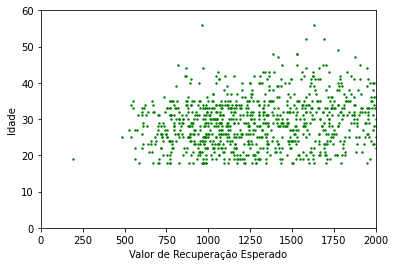

In [6]:
# Gráfico de dispersão de Idade vs. Valor de Recuperação Esperado
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="g", s=2)
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel('Valor de Recuperação Esperado')
plt.ylabel('Idade')
plt.show()

## 3. Teste estatístico: idade vs. valor de recuperação esperado
Queremos nos convencer de que variáveis ​​como idade e sexo são semelhantes acima e abaixo do limite de \$1.000 Valor de Recuperação Esperada. Isso é importante porque queremos poder concluir que as diferenças no valor de recuperação real são devidas à estratégia de recuperação mais alta e não devido a alguma outra diferença, como idade ou sexo.

O gráfico de dispersão da idade versus Valor de recuperação esperado não mostrou um salto óbvio em torno de \$1.000. Faremos agora uma análise estatística examinando a idade média dos clientes logo acima e logo abaixo do limite. Podemos começar explorando a faixa de \$900 a \$1100.

Para determinar se há diferença nas idades logo acima e logo abaixo do limiar, usaremos o <a href="https://pt.wikipedia.org/wiki/Teste_de_Kruskal-Wallis">teste de Kruskal-Wallis</a>, um teste estatístico que não faz suposições distributivas.

In [7]:
# Importar stats
from scipy import stats

# Calcular a idade média logo abaixo e acima do limite
era_900_1100 = df.loc[(df['expected_recovery_amount']< 1100) & 
                      (df['expected_recovery_amount']>= 900)]
by_recovery_strategy = era_900_1100.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().unstack()

# Usando o teste de Kruskal-Wallis 
Level_0_age = era_900_1100.loc[df['recovery_strategy'] == "Level 0 Recovery"]['age']
Level_1_age = era_900_1100.loc[df['recovery_strategy'] == "Level 1 Recovery"]['age']
stats.kruskal(Level_0_age,Level_1_age) 

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

## 4. Teste estatístico: sexo vs. valor de recuperação esperado
Vimos que não há grande salto na idade média do cliente logo acima e logo
abaixo do limite de \$1000 fazendo um teste estatístico, bem como explorando-o graficamente com um gráfico de dispersão.
Também queremos testar se a porcentagem de clientes do sexo masculino não ultrapassa o limite de \$1.000. Podemos começar explorando a faixa de \$900 a \$1100 e posteriormente ajustar essa faixa.
Podemos examinar esta questão estatisticamente desenvolvendo tabelas cruzadas, bem como fazendo um  <a href="https://en.wikipedia.org/wiki/Chi-squared_test">teste Chi-square</a> da porcentagem de clientes masculinos versus femininos.

In [8]:
# Número de clientes em cada categoria
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<1100) & 
                              (df['expected_recovery_amount']>=900)]['recovery_strategy'], 
                       df['sex'])
print(crosstab)

# Teste Chi-square 
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
p_val

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55


0.5377947810444592

## 5. Análise gráfica exploratória: montante de recuperação
Agora estamos razoavelmente confiantes de que os clientes logo acima e logo abaixo do limite de $ 1.000 são, em média, semelhantes em sua idade média e na porcentagem de homens.

Agora é hora de focar no principal resultado dos juros, o Valor Real de Recuperação.

Um primeiro passo para examinar a relação entre o valor real de recuperação  e o valor de recuperação esperado é desenvolver um gráfico de dispersão onde queremos focar nossa atenção no intervalo logo abaixo e logo acima do limite. Especificamente, desenvolveremos um gráfico de dispersão do Valor de Recuperação Esperado (X) versus Valor de Recuperação Real (Y) para Valores de Recuperação Esperados entre \$900 e \$1100. Este intervalo abrange os níveis 0 e 1. Uma questão-chave é se vemos ou não uma descontinuidade (salto) em torno do limite de \$1000.

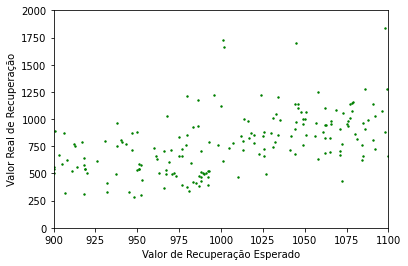

In [9]:
# Gráfico de dispersão do Valor Real de Recuperação  vs. Valor de Recuperação Esperado 
plt.scatter(x=df['expected_recovery_amount'], y=df['actual_recovery_amount'], c="g", s=2)
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Valor de Recuperação Esperado")
plt.ylabel("Valor Real de Recuperação")
plt.show()

## 6. Análise estatística: montante de recuperação
Assim como fizemos com a idade, podemos realizar testes estatísticos para ver se o valor de recuperação real apresenta uma descontinuidade acima do limite de \$1.000. Faremos isso para duas janelas diferentes do valor de recuperação esperado \$900 a \$1100 e para um intervalo menor, de \$950 a \$1050, para ver se nossos resultados são consistentes.

Novamente, usaremos o teste de Kruskal-Wallis.

Primeiro calcularemos o valor médio real de recuperação para os clientes logo abaixo e logo acima do limite usando um intervalo de \$900 a \$1100. Em seguida, realizaremos um teste de Kruskal-Wallis para ver se os valores reais de recuperação são diferentes logo acima e logo abaixo do limite. Feito isso, repetiremos essas etapas para uma janela menor de \$950 a \$1050.

In [ ]:
# Calcula o valor médio real de recuperação logo abaixo e acima do limite
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Teste de Kruskal-Wallis
Level_0_actual = era_900_1100.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_900_1100.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
stats.kruskal(Level_0_actual, Level_1_actual) 

# Repitindo para um intervalo menor de $ 950 a $ 1050
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]

Level_0_actual = era_950_1050.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_950_1050.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
stats.kruskal(Level_0_actual, Level_1_actual) 

KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)

## 7. Modelagem de regressão: sem limite
Agora queremos adotar uma abordagem baseada em regressão para estimar o impacto do programa no limite de \$1.000 usando dados que estão logo acima e abaixo do limite.

Faremos dois modelos. O primeiro modelo não possui um limite, enquanto o segundo incluirá um limite.

O primeiro modelo prevê o valor de recuperação real (variável dependente) em função do valor de recuperação esperado (variável independente). Esperamos que haja uma forte relação positiva entre essas duas variáveis.

Examinaremos o R-quadrado ajustado para ver a porcentagem de variância explicada pelo modelo. Neste modelo, não estamos representando o limite, mas simplesmente vendo como a variável usada para atribuir os clientes (valor de recuperação esperado) se relaciona com a variável de resultado (valor de recuperação real).

In [ ]:
# Importando statsmodels
import statsmodels.api as sm

# Definindo X e y
X = era_900_1100['expected_recovery_amount']
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Construindo um modelo de regressão linear
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Imprimindo as estatísticas de resumo do modelo
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Wed, 01 Feb 2023   Prob (F-statistic):           1.56e-13
Time:                            12:41:17   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 8. Modelagem de regressão: adicionando limite verdadeiro
Do primeiro modelo, vemos que o coeficiente de regressão do valor esperado de recuperação é estatisticamente significativo.

O segundo modelo adiciona um indicador do limite verdadeiro ao modelo (neste caso em \$1000).

Criaremos uma variável indicadora (0 ou 1) que representa se o valor de recuperação esperado foi ou não maior que \$1.000. Quando adicionamos o limite verdadeiro ao modelo, o coeficiente de regressão para o limite verdadeiro representa a quantidade adicional recuperada devido à estratégia de recuperação mais alta. Ou seja, o coeficiente de regressão para o limite verdadeiro mede o tamanho da descontinuidade para clientes logo acima e logo abaixo do limite.
Se a estratégia de recuperação mais alta ajudou a recuperar mais dinheiro, o coeficiente de regressão do limite verdadeiro será maior que zero. Se a estratégia de recuperação mais alta não ajudou a recuperar mais dinheiro, o coeficiente de regressão não será estatisticamente significativo.

In [ ]:
# Criando indicador (0 ou 1) para valor de recuperação esperado >= $ 1000
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]

# Definindo X e y
X = era_900_1100[['expected_recovery_amount','indicator_1000']]
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Construindo um modelo de regressão linear
model = sm.OLS(y,X).fit()

# Imprimindo as estatísticas de resumo do modelo
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Wed, 01 Feb 2023   Prob (F-statistic):           1.83e-15
Time:                            12:42:58   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        3.3440    626.274      0.005      0.996   -1232.440    1239.128
expected_recovery_amount     0.6430      0.655      0.981      0.328      -0.650       1.936
indicator_1000             277.6344     74.043      3.750      0.000     131.530     423.739
==============================================================================
Omnibus:                       65.977   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.537
Skew:                           1.510   Prob(JB):                     3.12e-41
Kurtosis:                       6.917   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 9. Modelagem de regressão: ajustando a janela
O coeficiente de regressão para o limiar verdadeiro foi estatisticamente significativo com um impacto estimado em torno de \$278. Isso é muito maior do que os $ 50 por cliente necessários para executar essa estratégia de recuperação mais alta.

Antes de mostrar isso ao nosso gerente, queremos nos convencer de que esse resultado não foi devido à escolha de uma janela de valor de recuperação esperada de \$900 a \$1100. Vamos repetir esta análise para a janela de \$950 a \$1050 para ver se obtemos resultados semelhantes.

A resposta? Quer usemos uma janela ampla (\$900 a \$1100) ou mais estreita (\$950 a \$1050), o valor da recuperação incremental na estratégia de recuperação mais alta é muito maior do que os \$ ​​50 por cliente que custa para a estratégia de recuperação mais alta. Portanto, concluímos que a estratégia de recuperação mais alta vale o custo extra de \$50 por cliente.

In [ ]:
# Redefinindo era_950_1050 para que a variável indicadora seja incluída
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]

# Definindo X e y
X = era_950_1050[['expected_recovery_amount','indicator_1000']]
y = era_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Construindo um modelo de regressão linear
model = sm.OLS(y,X).fit()

# Imprimindo as estatísticas de resumo do modelo
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Wed, 01 Feb 2023   Prob (F-statistic):           1.12e-07
Time:                            12:44:41   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""